## Portafolio del gus

Se tiene un dataset que muestra la cantidad de visitantes turistas en una atracción con respecto al tiempo, y se tiene el objetivo de poder realizar un modelo que pueda pronosticar la cantidad de turistas en un futuro. Para comenzar, realizaremos las importaciones necesarias para poder elaborar el modelo y probarlo en distintos escenarios.

In [36]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,kpss # to do ADF test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA # to do predictions
from sklearn.model_selection import train_test_split
import requests, io #type: ignore
import pmdarima as pm

data = pd.read_csv("data.csv")

Primero se grafica el dataset para entender como es formado, y poder identificar si es que cuenta con alguna tendencia o tiene aspectos de estacionariedad.

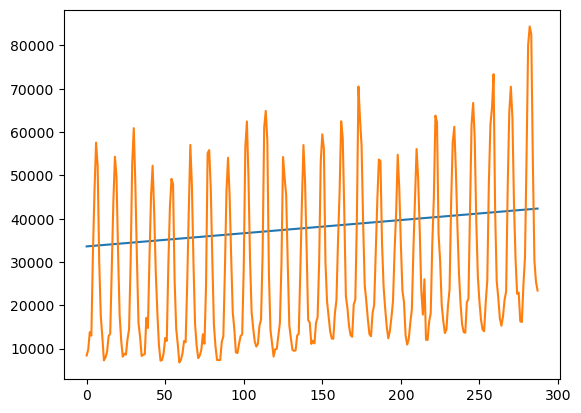

In [37]:
plt.plot(data)
plt.show()


Ahora realizamos un Q-test, esto con el objetivo de determinar si es que existe autocorrelación de los datos dentro de la seria para utilizar un modelo ARIMA.

In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data["TouristNumber"].values)


,lb_stat,lb_pvalue
1,192.180851,1.062459e-43
2,243.347584,1.437949e-53
3,243.435422,1.720184e-52
4,282.414013,6.721979e-60
5,374.506023,9.237014e-79
6,488.136851,3.019824e-102
7,576.349319,3.010715e-120
8,611.975920,6.227934e-127
9,612.088155,5.325059e-126
10,656.970266,1.076157e-134


Como se puede observar, el p-value es bastante pequeño así que podemos concluir que si hay autocorrelación en la series.
Igualmente podemos notar una pequeña tendencia en la gráfica en los datos, así que usaremos la diferenciación para quitar esta tendencia.

Ahora definiremos el método para poder testear si es que la serie de datos cuenta con estacionariedad, realizando el test de Dickey-Fuller y de KPSS

In [39]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(timeseries):

    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

    print('Results of kpss Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

Ahora se aplica este método a los datos, y podremos notar sus características en la gráfica

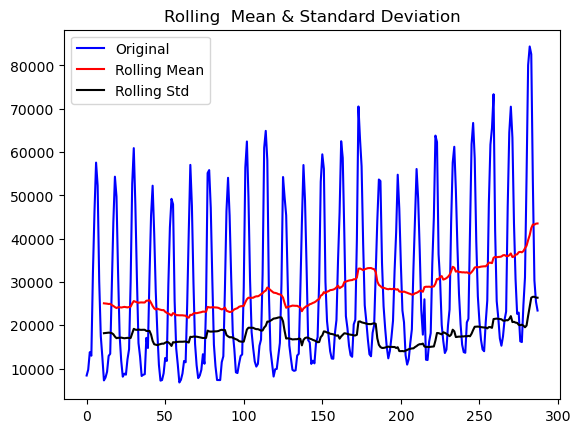

Results of Dickey-Fuller Test:
Test Statistic                   1.247470
p-value                          0.996298
#Lags Used                      13.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64
Results of kpss Test:
Test Statistic           0.976983
p-value                  0.010000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/wg/0ry_2kxj1cjg6v6gw1kzvv_40000gn/T/ipykernel_47508/1268464633.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [40]:
test_stationarity(pd.Series(data["TouristNumber"].values))


Ahora aplicaremos la diferenciación y guardaremos el resultado en una variable para poder reutilizarla en un futuro

In [41]:
from statsmodels.tsa.statespace.tools import diff
differentiated = diff(data["TouristNumber"],k_diff=1)


Ya una vez aplicada la diferenciación, se le aplica el test de diferenciación nuevamente para poder notar los cambios en el dataset

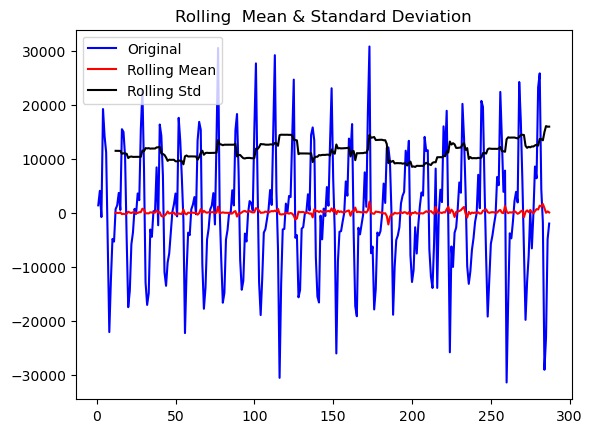

Results of Dickey-Fuller Test:
Test Statistic                -8.170180e+00
p-value                        8.665018e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.740000e+02
Critical Value (1%)           -3.454444e+00
Critical Value (5%)           -2.872147e+00
Critical Value (10%)          -2.572422e+00
dtype: float64
Results of kpss Test:
Test Statistic           0.008515
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/wg/0ry_2kxj1cjg6v6gw1kzvv_40000gn/T/ipykernel_47508/1268464633.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [42]:
test_stationarity(differentiated)


Como parte del proceso de comprobación, se le realizará el Q-test al dataset diferenciado para poder evaluar los p-values

In [43]:
acorr_ljungbox(differentiated)


,lb_stat,lb_pvalue
1,90.715130,1.659196e-21
2,94.625831,2.833100e-21
3,111.168607,6.149364e-24
4,157.186406,5.865184e-33
5,193.851696,5.866321e-40
6,232.132248,2.685264e-47
7,266.990889,6.666578e-54
8,305.269367,3.111511e-61
9,320.115094,1.402019e-63
10,324.895704,8.379118e-64


Ahora se revisará la autocorrelación 

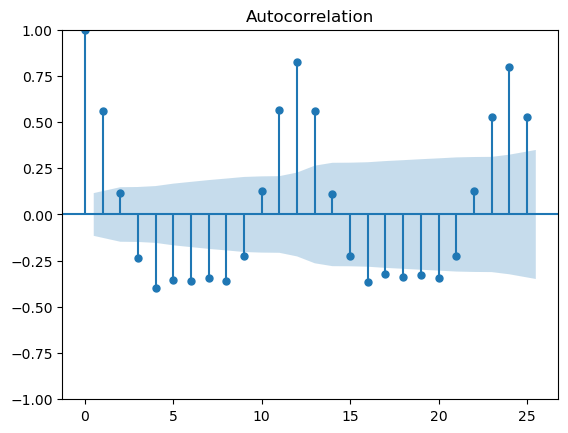

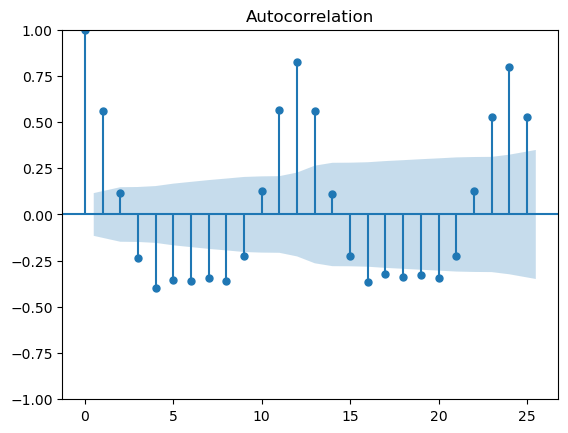

In [44]:
plot_acf(differentiated)


y también se revisará la autocorrelación parcial

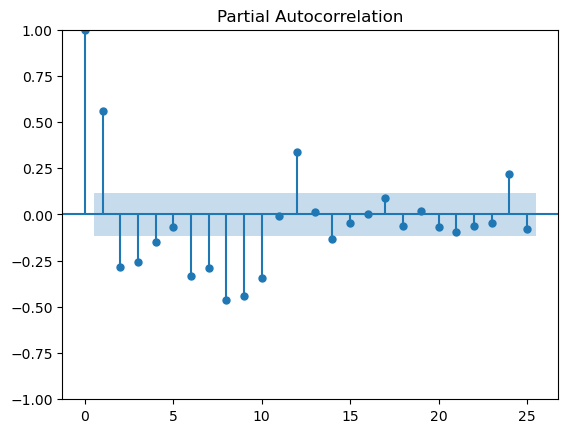

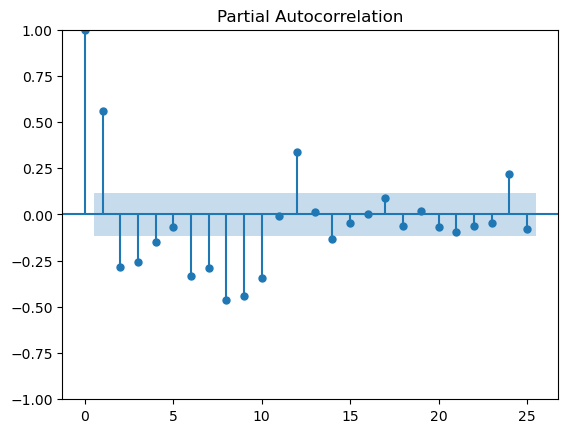

In [45]:
plot_pacf(differentiated)


Ahora se creara el modelo que se utilizará para la predicción (a aplicar d= 1, se aplicará a la serie original)

In [46]:
import statsmodels.api as sm
p = 15
d = 1
q = 15
model = sm.tsa.ARIMA(data["TouristNumber"], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())


/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:          TouristNumber   No. Observations:                  288
Model:               ARIMA(15, 1, 15)   Log Likelihood               -2767.957
Date:                Fri, 25 Oct 2024   AIC                           5597.914
Time:                        18:09:07   BIC                           5711.358
Sample:                             0   HQIC                          5643.380
                                - 288                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2140      1.078     -1.126      0.260      -3.327       0.899
ar.L2         -0.6038      0.522     -1.156      0.248      -1.628       0.420
ar.L3          0.0069      0.462      0.015      0.9

/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Ahora revisaremos el estado de los residuales

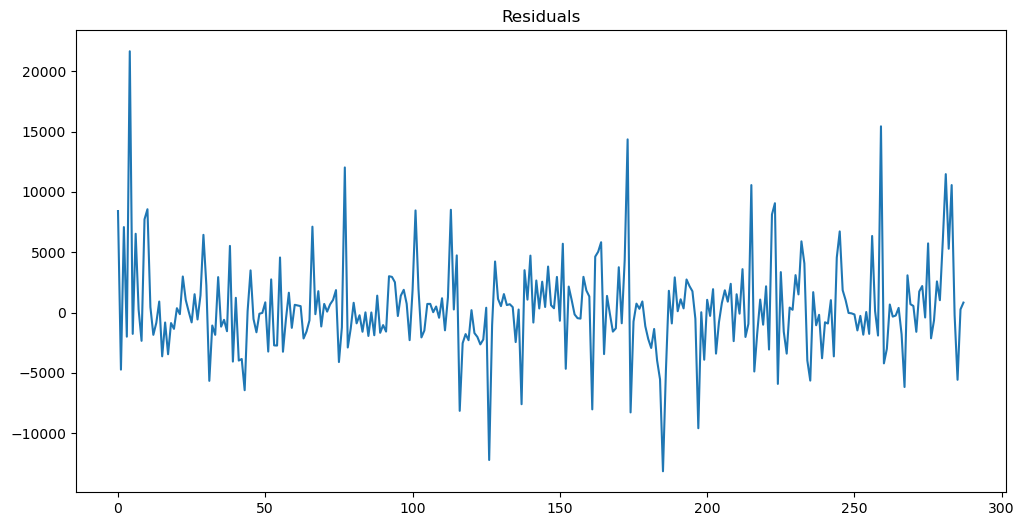

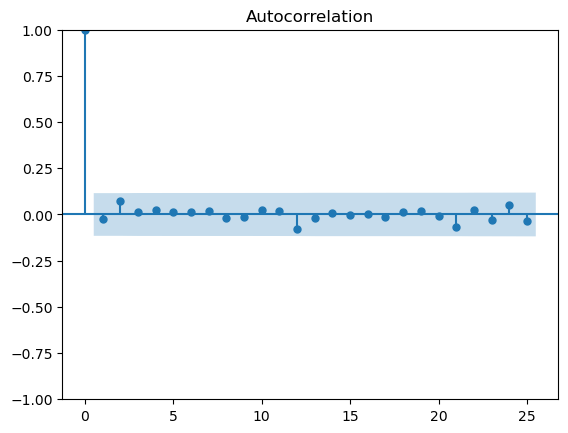

In [47]:
# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(model_fit.resid)
plt.title('Residuals')
plt.show()

# Plot the ACF of the residuals
plot_acf(model_fit.resid)
plt.show()

Le realizaremos el Q-test a los residuales para conocer su p-value

In [48]:
acorr_ljungbox(model_fit.resid)

,lb_stat,lb_pvalue
1,0.184834,0.667252
2,1.820062,0.402512
3,1.861242,0.601700
4,2.025625,0.731046
5,2.095210,0.835820
6,2.140765,0.906308
7,2.222947,0.946477
8,2.331972,0.969106
9,2.396992,0.983527
10,2.573076,0.989767


Y ahora le calculamos la suma de error cuadrátrico a estos datos

In [49]:
# Calculate the SSE of the residuals
sse = np.sum(np.square(model_fit.resid))
print(f"SSE of the residuals: {sse}")

SSE of the residuals: 4388870935.606285


Haremos uso de una herramienta que consiste en un procedimiento automatico para encontrar el mejor modelo. Este procedimiento evalúa los datos para encontrar el nivel de diferenciación y ajustes con la serie de datos en varios modelos. A esta herramiento se le conoce como AUTOARIMA



In [50]:
# Fit auto_arima to the data
auto_model = pm.auto_arima(data['TouristNumber'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# Print the summary of the best model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6169.098, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5992.445, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6167.106, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6067.022, Time=0.01 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5719.520, Time=0.58 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=5679.148, Time=1.22 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5645.677, Time=4.00 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=5752.923, Time=1.68 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=inf, T

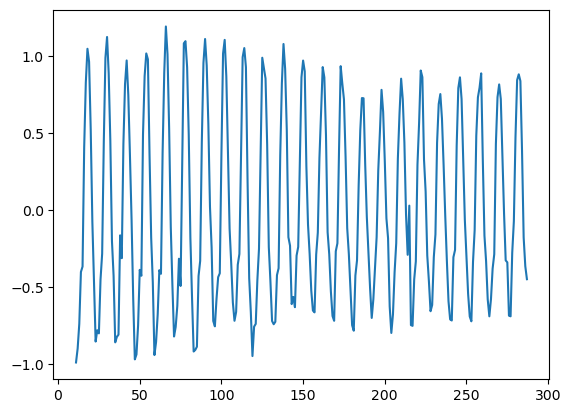

In [51]:
tslog2 = np.log(data['TouristNumber'])
rollavg = tslog2.rolling(12).mean()
tslogdiff = tslog2 - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

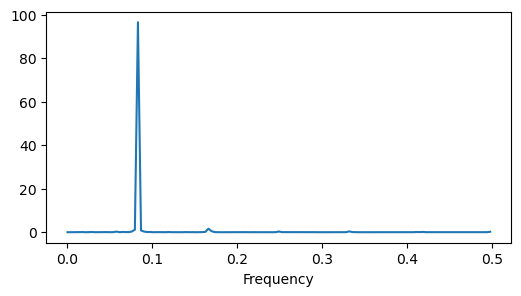

In [52]:
from scipy import signal
f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.show()


In [53]:
top_4_periods = {}

# get indices for 4 highest Pxx values
top4_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]


freqs = f[top4_freq_indices]

# use same indices to get powers as well
power = Pxx[top4_freq_indices]

# we are interested in period and it is calculated as 1/frequency
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_4_periods['period1'] = periods[0]
top_4_periods['freq1'] = freqs[0]
top_4_periods['power1'] = power[0]

top_4_periods['period2'] = periods[1]
top_4_periods['freq2'] = freqs[1]
top_4_periods['power2'] = power[1]

top_4_periods['period3'] = periods[2]
top_4_periods['freq3'] = freqs[2]
top_4_periods['power3'] = power[2]

top_4_periods['period4'] = periods[3]
top_4_periods['freq4'] = freqs[3]
top_4_periods['power4'] = power[3]


In [54]:
top_4_periods


{'period1': 12.043478260869565,
 'freq1': 0.08303249097472924,
 'power1': 96.56908333532222,
 'period2': 6.021739130434782,
 'freq2': 0.16606498194945848,
 'power2': 1.621721245972886,
 'period3': 12.59090909090909,
 'freq3': 0.07942238267148015,
 'power3': 1.1630201806769747,
 'period4': 11.541666666666666,
 'freq4': 0.08664259927797835,
 'power4': 0.8182734772187514}

In [55]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    freqencies, spectrum = periodogram(ts)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1/12, 1/6, 1/4, 1/3, 1/2])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "3 months",
            "Bimonthly (6)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


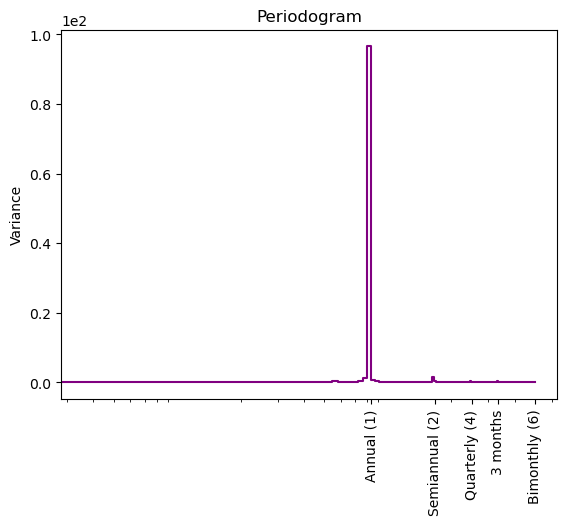

In [56]:
plot_periodogram(tslogdiff)
plt.show()

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(data['TouristNumber'], model='multiplicative',period=12)

<Axes: >

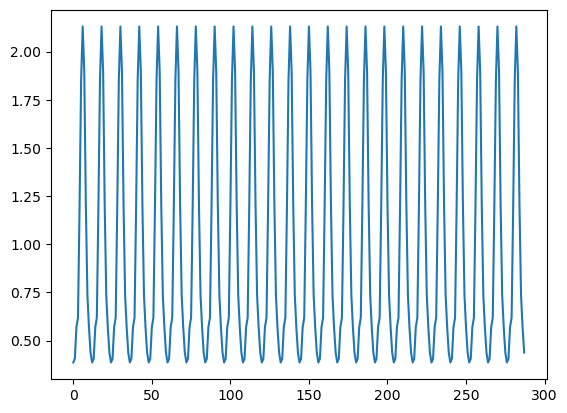

In [58]:
result.seasonal.plot()

<Axes: >

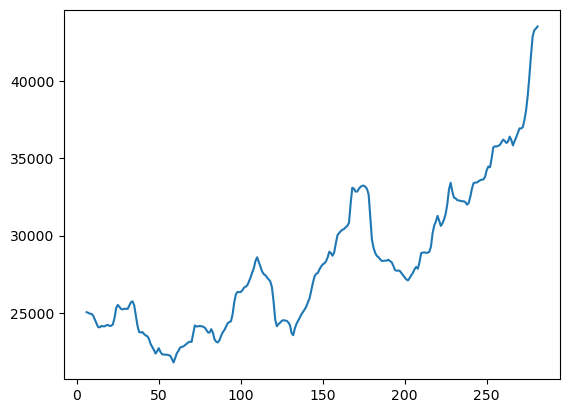

In [59]:
result.trend.plot()


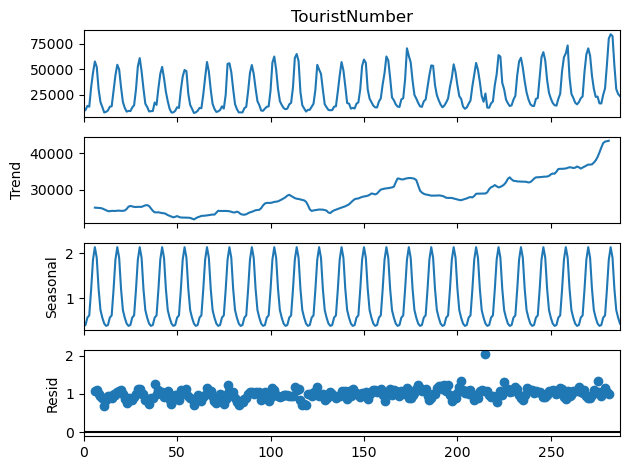

In [60]:
result.plot()
plt.show()

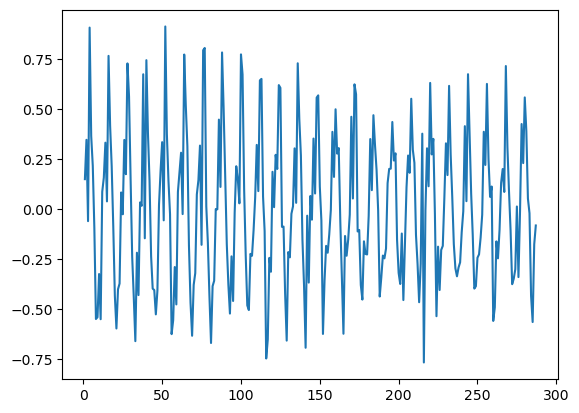

In [61]:
tslog = np.log(data['TouristNumber'])
logret= diff(tslog)
plt.plot(logret)
plt.show()

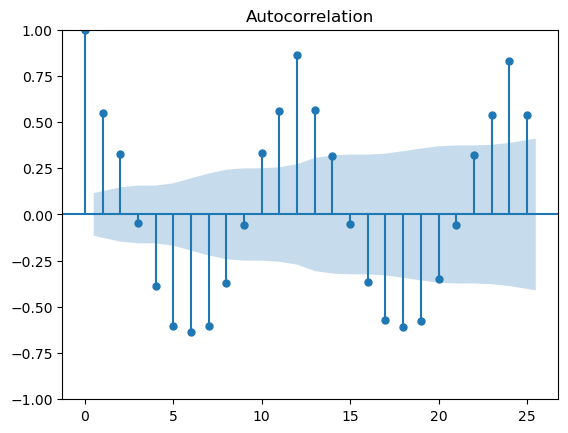

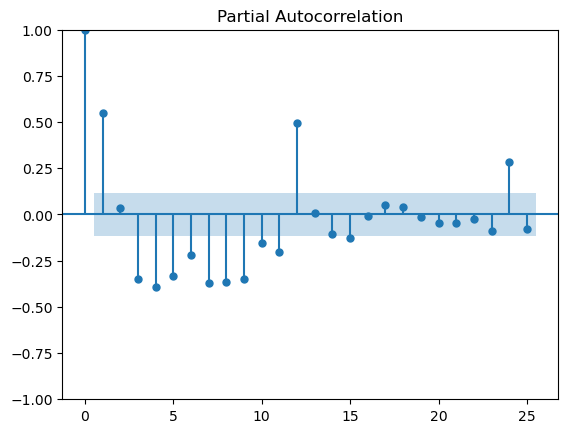

In [62]:
plot_acf(logret)
plot_pacf(logret)
plt.show()

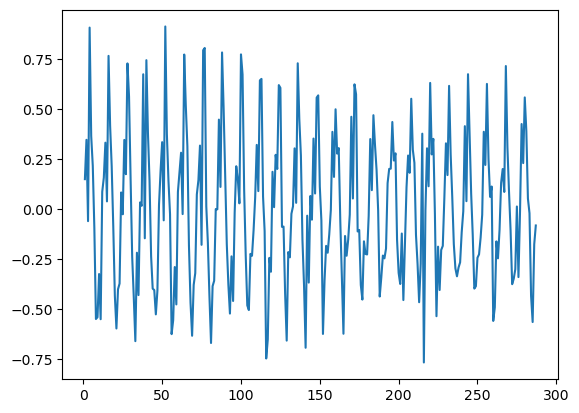

In [63]:
slogret= diff(diff(tslog),k_seasonal_diff=1,seasonal_periods=12)
plt.plot(logret)
plt.show()

In [64]:
m = int(np.log(data.shape[0]))

acorr_ljungbox(slogret, lags=[m])

,lb_stat,lb_pvalue
5,101.524366,2.521779e-20


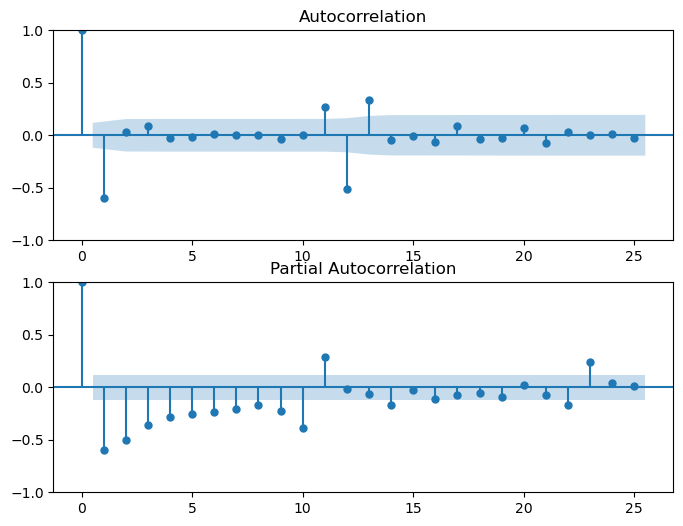

In [65]:
fig,ax = plt.subplots(2,1,figsize=(8,6))
plot_acf(slogret,ax=ax[0])
plot_pacf(slogret,ax=ax[1])
plt.show()

In [66]:
import statsmodels.api as sm
pp = []
qq = []
PP = []
QQ = []
aic = []
lb = []
sse = []
for p in range(0,2):
    for q in range(0,2):
        for P in range(0,2):
            for Q in range(0,2):
                model=sm.tsa.statespace.SARIMAX(np.log(data['TouristNumber']),order=(p, 1, q),seasonal_order=(P,1,Q,12))
                res = model.fit()
                pp.append(p)
                qq.append(q)
                PP.append(P)
                QQ.append(Q)
                aic.append(res.aic)
                lb.append(acorr_ljungbox(res.resid, lags=[m]))
                sse.append((res.resid**2).sum())

resdf = pd.DataFrame()
resdf['p']=pp
resdf['q']=qq
resdf['PP']=PP
resdf['QQ']=QQ
resdf['AIC']=aic
resdf['lb-p-value']=lb
resdf['sse']=sse

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98536D-01    |proj g|=  2.89641D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     14      1     0     0   7.522D-04  -3.991D-01
  F = -0.39905310015373435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.0

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     24      1     0     0   5.520D-05  -6.184D-01
  F = -0.61843577305770181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44785D-01    |proj g|=  2.19576D-01

At iterate    5    f= -5.45093D-01    |proj g|=  7.99638D-02

At iterate   10    f= -5.45209D-01    |proj g|=  3.05399D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -6.22262D-01    |proj g|=  1.08199D-01

At iterate   15    f= -6.23536D-01    |proj g|=  3.34152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   4.950D-04  -6.235D-01
  F = -0.62353733808157985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.43443D-01    |proj g|=  2.88816D-01

At iterate    5    f= -5.48534D-01    |proj g|=  6.00515D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -5.61396D-01    |proj g|=  8.54642D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     16      1     0     0   1.941D-05  -5.614D-01
  F = -0.56140176029537925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.78959D-01    |proj g|=  2.45382D+00

At iterate    5    f= -7.21368D-01    |proj g|=  3.71694D-01

At iterate   10    f= -7.31654D-01    |proj g|=  2.21031D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   5.190D-05  -6.813D-01
  F = -0.68134184969797296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.80800D-01    |proj g|=  2.41481D+00

At iterate    5    f= -7.30020D-01    |proj g|=  4.26420D-01

At iterate   10    f= -7.36275D-01    |proj g|=  1.14953D-02

At iterate   15    f= -7.36276D-01    |proj g|=  5.98849D-04

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -6.76613D-01    |proj g|=  1.03587D-01

At iterate   10    f= -6.79622D-01    |proj g|=  7.74284D-02

At iterate   15    f= -6.79916D-01    |proj g|=  1.74446D-01

At iterate   20    f= -6.80438D-01    |proj g|=  2.68370D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   1.848D-05  -6.804D-01
  F = -0.68043832197775467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.32388D-01    |proj g|=  2.30297D+00

At iterate    5    f= -6.76392D-01    |proj g|=  5.91879D-01

At iterate   10    f= -6.85736D-01    |proj g|=  2.80716D-02

At iterate   15    f= -6.86215D-01    |proj g|=  1.16128D-01

At iterate   20    f= -6.86319D-01    |proj g|=  2.94854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   2.949D-04  -6.863D-01
  F = -0.68631851640388186     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f= -5.73466D-01    |proj g|=  1.83424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     28      1     0     0   8.291D-06  -5.735D-01
  F = -0.57346636027021747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.93539D-01    |proj g|=  2.61048D+00

At iterate    5    f= -7.41056D-01    |proj g|=  2.97476D-01

At iterate   10    f= -7.50045D-01    |proj g|=  6.22121D-02

At itera

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61817D-01    |proj g|=  2.02539D+00

At iterate    5    f= -6.87958D-01    |proj g|=  3.70781D-02

At iterate   10    f= -6.90276D-01    |proj g|=  1.74515D-01

At iterate   15    f= -6.90706D-01    |proj g|=  6.78276D-02

At iterate   20    f= -6.91440D-01    |proj g|=  2.79686D-01

At iterate   25    f= -6.91995D-01    |proj g|=  1.08204D-02

At iterate   30    f= -6.91998D-01    |proj g|=  2.48092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -7.36606D-01    |proj g|=  3.09431D-01

At iterate   10    f= -7.46310D-01    |proj g|=  9.38279D-02

At iterate   15    f= -7.51534D-01    |proj g|=  5.59988D-01

At iterate   20    f= -7.53253D-01    |proj g|=  9.34717D-02

At iterate   25    f= -7.54839D-01    |proj g|=  7.25068D-02

At iterate   30    f= -7.56381D-01    |proj g|=  5.05281D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     44      1     0     0   5.099D-05  -7.564D-01
  F = -0.75638115129512862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [67]:
resdf

,p,q,PP,QQ,AIC,lb-p-value,sse
0,0,0,0,0,-227.854586,lb_stat lb_pvalue 5 3.60725 0.607225,110.476395
1,0,0,0,1,-352.219005,lb_stat lb_pvalue 5 4.026372 0.545625,107.852064
2,0,0,1,0,-310.040269,lb_stat lb_pvalue 5 3.807001 0.577524,108.590446
3,0,0,1,1,-353.157507,lb_stat lb_pvalue 5 4.022224 0.546221,107.798222
4,0,1,0,0,-319.367414,lb_stat lb_pvalue 5 4.253104 0.51358,108.450231
5,0,1,0,1,-416.341018,lb_stat lb_pvalue 5 4.329643 0.502995,106.919854
6,0,1,1,0,-386.452905,lb_stat lb_pvalue 5 4.289475 0.508535,107.324024
7,0,1,1,1,-416.095165,lb_stat lb_pvalue 5 4.323755 0.503805,106.894210
8,1,0,0,0,-270.095234,lb_stat lb_pvalue 5 3.692326 0.594506,109.435688
9,1,0,0,1,-385.932473,lb_stat lb_pvalue 5 4.083842 0.537409,107.322965


In [68]:
model=sm.tsa.statespace.SARIMAX(np.log(data['TouristNumber']),order=(1, 0, 1),seasonal_order=(1,1,0,12))
res = model.fit()
res.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.65253D-01    |proj g|=  1.31065D+00

At iterate    5    f= -6.84009D-01    |proj g|=  1.06791D+00

At iterate   10    f= -6.96839D-01    |proj g|=  6.26659D-02

At iterate   15    f= -6.98408D-01    |proj g|=  1.99828D-01



 This problem is unconstrained.


At iterate   20    f= -7.05196D-01    |proj g|=  1.33208D-02

At iterate   25    f= -7.05242D-01    |proj g|=  5.65589D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   3.994D-05  -7.052D-01
  F = -0.70524241885615147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       TouristNumber   No. Observations:                  288
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                 203.110
Date:                             Fri, 25 Oct 2024   AIC                           -398.220
Time:                                     18:09:41   BIC                           -383.738
Sample:                                          0   HQIC                          -392.408
                                             - 288                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8835      0.046     19.097      0.000       0.793       0.974
ma.L1         -0.5436      0.074     -7.344      0.000      -0.689      -0.399
ar.S.L12      -0.4716      0.040    -11.908      0.000      -0.549      -0.394
sigma2         0.0133      0.001     18.236      0.000       0.012       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               119.33
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.61
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

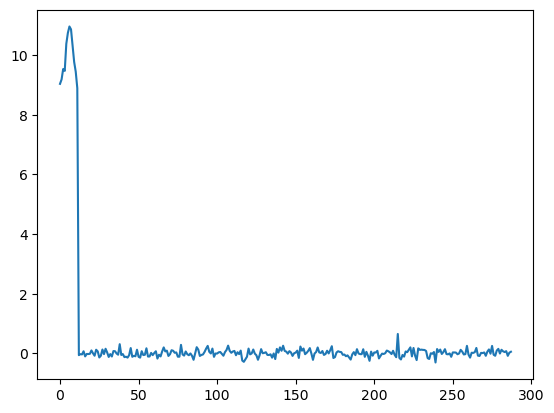

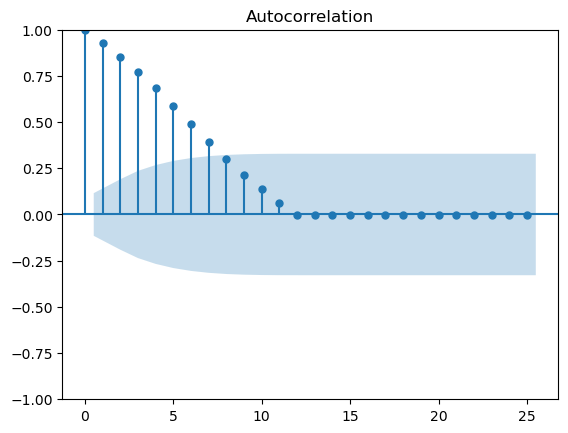

In [69]:
plt.plot(res.resid)
plot_acf(res.resid)
plt.show()

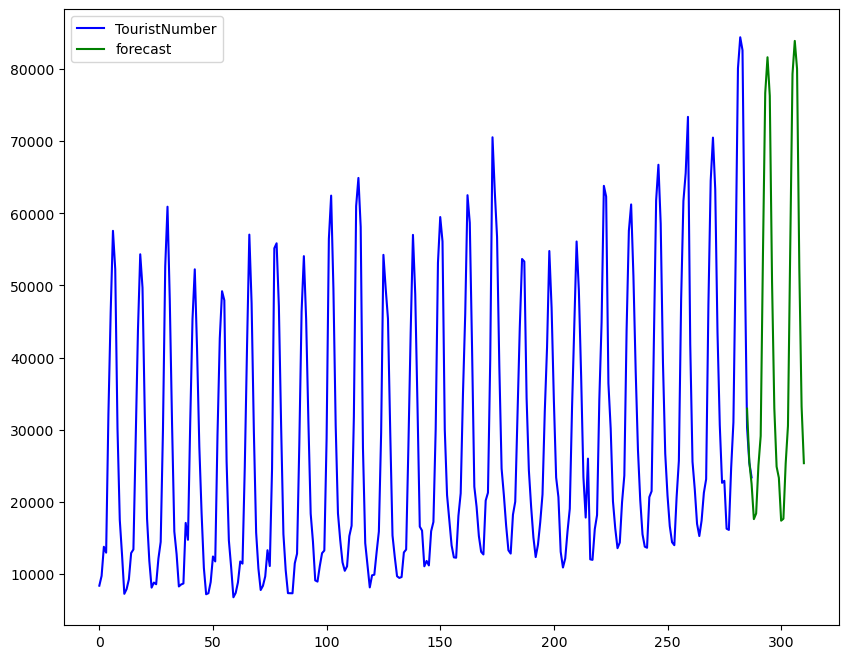

In [70]:
forecast=np.exp(res.predict(start=285,end=310,signal_only=True,dynamic=True))

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(data.index,data['TouristNumber'],label='TouristNumber',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

Hasta aqui mi participación :D